## Preliminaries

In [125]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms

In [126]:
data_path = "/home/sravula/experiments/datasets/8047_vel_imgs.npy"

In [127]:
from datasets.velocity_fine import Velocity

tran_transform = transforms.Compose([
    transforms.Resize([256, 256])
])

dataset = Velocity(path=data_path, transform=tran_transform)

In [128]:
N = len(dataset)
indices = list(range(N))
random_state = np.random.get_state()
np.random.seed(2240)
np.random.shuffle(indices)
np.random.set_state(random_state)
train_indices, test_indices = indices[:int(N * 0.9)], indices[int(N * 0.9):]

In [129]:
test_dataset = torch.utils.data.Subset(dataset, test_indices)

In [130]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=15, shuffle=False,
                         num_workers=8, drop_last=True)

test_iter = iter(test_loader)

test_sample = next(test_iter)[0]
test_sample = next(test_iter)[0]
test_sample = next(test_iter)[0]

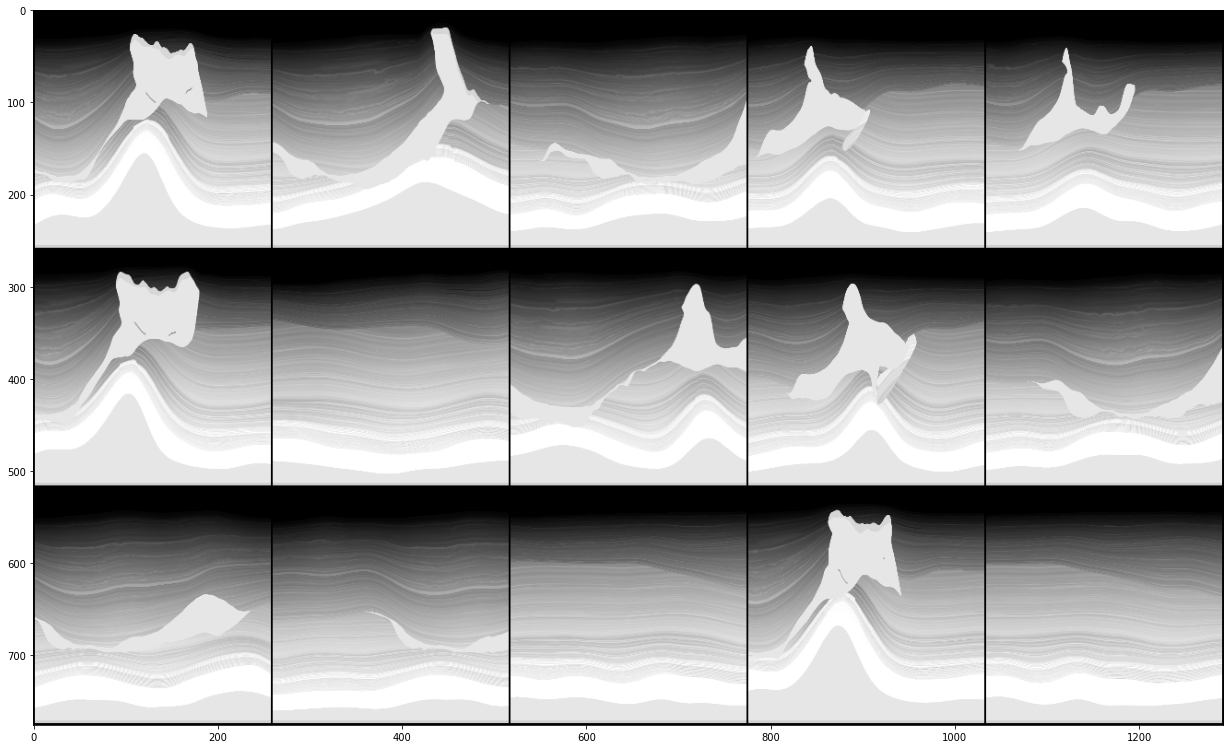

In [131]:
grid_img = torchvision.utils.make_grid(test_sample, nrow=5)

dpi = matplotlib.rcParams['figure.dpi']

height = width = 6*256
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Create Measurements

In [132]:
#We want y = Ax where A is a random Gaussian
#y = [N, m, 1], A = [N, m, C x W x H], x = [N, C, H, W]

N, C, H, W = test_sample.shape

m = C*H*W // 50

In [133]:
A = (1 / np.sqrt(m)) * torch.randn(m, C*H*W) #CS
#A = torch.eye(C*H*W)[np.random.choice(a=C*H*W, size=m, replace=False).tolist()] #random inpainting

#y = torch.matmul(A, test_sample.view(N, -1, 1)) #for forward problems
y = test_sample + 0.05*torch.randn((N, C, H, W)) #for denoising

print(A.shape)
print(y.shape)
print(test_sample.shape)

torch.Size([1310, 65536])
torch.Size([15, 1, 256, 256])
torch.Size([15, 1, 256, 256])


## Load the network and see the outputs with test samples

In [134]:
ckpt_path = "/home/sravula/experiments/logs/run_2/checkpoint.pth"
config_path = "/home/sravula/ncsnv2/configs/velocity.yml"

In [135]:
import argparse
from main import dict2namespace
import yaml

with open(config_path, 'r') as f:
    config = yaml.load(f)
new_config = dict2namespace(config)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
new_config.device = device

print(device)

/home/sravula/venvs/ncsnv2/lib64/python3.6/site-packages/ipykernel_launcher.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


cuda


In [136]:
from models.ncsnv2 import NCSNv2Deepest
from models.ema import EMAHelper
from models import get_sigmas

new_config.input_dim = new_config.data.image_size ** 2 * new_config.data.channels

score = NCSNv2Deepest(new_config).to(new_config.device)
score = torch.nn.DataParallel(score)

#Set up the exponential moving average
if new_config.model.ema:
    ema_helper = EMAHelper(mu=new_config.model.ema_rate)
    ema_helper.register(score)

states = torch.load(ckpt_path)
score.load_state_dict(states[0])
### Make sure we can resume with different eps
states[1]['param_groups'][0]['eps'] = new_config.optim.eps

if new_config.model.ema:
    ema_helper.load_state_dict(states[4])

#grab all L noise levels
sigmas = get_sigmas(new_config)

In [137]:
test_score = ema_helper.ema_copy(score)

test_score.eval();

In [138]:
with torch.no_grad():
    labels = torch.ones(test_sample.shape[0], device=test_sample.device) * 1099
    labels = labels.long()

    grad = test_score(test_sample, labels)
    
    prior_norm = torch.norm(grad.view(grad.shape[0], -1), dim=-1).mean()

print("Mean L2-Norm of s(x) = \grad_x log p(x) of test samples: ", prior_norm.item())

Mean L2-Norm of s(x) = \grad_x log p(x) of test samples:  10033.029296875


## Set up and run Inverse Solver

In [142]:
from models import inverse_solver
import time

N, C, H, W = test_sample.shape
print(N, C, H, W)

y = y.to(new_config.device)

#A = A.to(new_config.device) #for forward problems
A = None #for denoising

x0 = torch.rand(N, C, H, W, device=new_config.device)

mse = torch.nn.MSELoss()
mse_start = mse(x0, test_sample.to(new_config.device))
print("Start MSE: ", mse_start.item())

start = time.time()

num_iters = 200

lr = [0.001, 0.0001]

15 1 256 256
Start MSE:  0.022568712010979652


In [143]:
all_samples = inverse_solver(x_mod = x0, 
                             y = y, 
                             A = A, 
                             scorenet = test_score, 
                             sigmas = sigmas.cpu().numpy(), 
                             lr = lr, 
                             c1=1,
                             c2=1,
                             auto_c2=True,
                             final_only=False, 
                             verbose=True, 
                             likelihood_every=1,
                             decimate_sigma=1100//num_iters,
                             mode='denoising', 
                             true_x=test_sample.to(new_config.device), 
                             sigma_type = 'last',
                             likelihood_type="l2")

print("\nTOTAL TIME: ", time.time() - start)


 iteration: 0, sigma: 0.0100, step_size: 0.0010, prior_norm: 25529.3105, likelihood_norm: 25529.3105, grad_norm: 36199.9102                         image_norm: 180.1465, train_mse: 0.0000
true_mse: 0.0125

 iteration: 1, sigma: 0.0100, step_size: 0.0010, prior_norm: 25508.7383, likelihood_norm: 3596214.0000, grad_norm: 3604119.5000                         image_norm: 3562.1621, train_mse: 0.0198
true_mse: 193.1107

 iteration: 2, sigma: 0.0100, step_size: 0.0010, prior_norm: 25641.5430, likelihood_norm: 352482464.0000, grad_norm: 352508096.0000                         image_norm: 341615.3438, train_mse: 190.1828
true_mse: 1780726.3750

 iteration: 3, sigma: 0.0100, step_size: 0.0010, prior_norm: 25609.1094, likelihood_norm: 34110244864.0000, grad_norm: 34110269440.0000                         image_norm: 32709530.0000, train_mse: 1781007.3750
true_mse: 16325651456.0000

 iteration: 4, sigma: 0.0100, step_size: 0.0010, prior_norm: 25608.5215, likelihood_norm: 3265779204096.0000, grad_n

KeyboardInterrupt: 

In [ ]:
sample = x0.cpu()

sample = torch.clamp(sample, 0.0, 1.0)

grid_img = torchvision.utils.make_grid(sample, nrow=5)

dpi = matplotlib.rcParams['figure.dpi']

height = width = 6*256
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
plt.title("INITIALISATION")
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

for i in range(len(all_samples)//10):
    sample = all_samples[i*10].view(all_samples[i*10].shape[0], new_config.data.channels,
                                  new_config.data.image_size,
                                  new_config.data.image_size)

    sample = torch.clamp(sample, 0.0, 1.0)

    grid_img = torchvision.utils.make_grid(sample, nrow=5)

    dpi = matplotlib.rcParams['figure.dpi']

    height = width = 6*256
    figsize = width / float(dpi), height / float(dpi)

    plt.figure(figsize=figsize)
    plt.title("ITERATION" + str(i*10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()